# RNN Project 2: Character-level Language Modeling

### Creating the Dataset

In [1]:
import numpy as np

with open("1268-0.txt", "r", encoding="utf8") as fp:
    text = fp.read()
    start_idx = text.find("THE MYSTERIOUS ISLAND")
    end_idx = text.find("End of the Project Gutenberg")
    # remove prologue and end jibber jabber
    text = text[start_idx:end_idx]
    # create a set of unique characters
    char_set = set(text)
    print(f"Total length of text: {len(text)}")
    print(f"Unique characters: {len(char_set)}")

Total length of text: 1130711
Unique characters: 85


Most NN and RNN libraries cannot deal with string inputs, so we will convert text into a numeric format.

In [2]:
chars_sorted = sorted(char_set)
char2int = {ch:i for i,ch in enumerate(chars_sorted)} # char to int mapping

# reverse mapping from int to char (more efficient)
char_array = np.array(chars_sorted)
print(f"Char array: {char_array[:15]}")
text_encoded = np.array([char2int[ch] for ch in text], dtype=np.int32)

print(f"Text encoded shape: {text_encoded.shape}")
print(f"{text[:15]} ==Encoding==> {text_encoded[:15]}")

Char array: ['\n' ' ' '!' '"' '$' '%' '&' "'" '(' ')' '*' ',' '-' '.' '/']
Text encoded shape: (1130711,)
THE MYSTERIOUS  ==Encoding==> [48 36 33  1 41 53 47 48 33 46 37 43 49 47  1]


In [3]:
for ex in text_encoded[:5]:
    print(f"{ex} -> {char_array[ex]}")

48 -> T
36 -> H
33 -> E
1 ->  
41 -> M


Make the shifted sequences (each of length 41). Input will be first 40 and label will the shifted 40. So $x$ will be from 0 to 39 while $y$ is 1 to 40. With this, we can just run a **classification problem** since the number of unique classes is fixed. 

In [4]:
import torch
from torch.utils.data import Dataset

seq_length = 40
chunk_size = seq_length + 1
text_chunks = [text_encoded[i:i+chunk_size] for i in range(len(text_encoded) - chunk_size)]

In [5]:
class TextDataset(Dataset):
    def __init__(self, text_chunks):
        if isinstance(text_chunks, np.ndarray):
            text_chunks = torch.Tensor(text_chunks)
        self.text_chunks = text_chunks

    def __len__(self):
        return len(self.text_chunks)

    def __getitem__(self, idx):
        """
        Returns input x and label y 
        """
        assert idx < len(self)
        text_chunk = self.text_chunks[idx]
        return text_chunk[:-1].long(), text_chunk[1:].long()

seq_dataset = TextDataset(torch.Tensor(text_chunks))

/tmp/ipykernel_4498/1662308023.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  seq_dataset = TextDataset(torch.Tensor(text_chunks))


In [6]:
# take a look at example sequences of the dataset
for i, (seq, target) in enumerate(seq_dataset):
    print("Input (x): ", repr("".join(char_array[seq])))
    print("Target (y): ", repr("".join(char_array[target])))
    if i == 1: break

Input (x):  'THE MYSTERIOUS ISLAND ***\n\n\n\n\nTHE MYSTER'
Target (y):  'HE MYSTERIOUS ISLAND ***\n\n\n\n\nTHE MYSTERI'
Input (x):  'HE MYSTERIOUS ISLAND ***\n\n\n\n\nTHE MYSTERI'
Target (y):  'E MYSTERIOUS ISLAND ***\n\n\n\n\nTHE MYSTERIO'


In [7]:
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
seq_dl = DataLoader(seq_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

### Building a Character-level RNN

In [17]:
# progress bar and plotting
from tqdm.notebook import tqdm

import os

%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
use_GPU = True

if use_GPU:
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
else:
    device = torch.device("cpu")

print(f"Using device {device}")

Using device cuda


In [10]:
from turtle import forward
import torch.nn as nn 

class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, rnn_layer=nn.LSTM):
        super().__init__()
        self.rnn_hidden_size = rnn_hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = rnn_layer(embed_dim, rnn_hidden_size, batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, vocab_size) # multiple-to-multiple RNN
        self.softmax = nn.LogSoftmax(dim=1) # don't know why book did not have this line

    def forward(self, x, hidden, cell):
        """
        Forward function call for the LSTM.
        LMST takes in as input previous cell and hidden state and sequence value x(t).
        """
        out = self.embedding(x).unsqueeze(1)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))
        out = self.fc(out).reshape(out.size(0), -1)
        return out, hidden, cell

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.rnn_hidden_size)
        cell = torch.zeros(1, batch_size, self.rnn_hidden_size)
        return hidden, cell

In [11]:
vocab_size = len(char_array)
embed_dim = 256
rnn_hidden_size = 512
torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size)
print(model)

model_path = "rnn_state_proj_2.pt"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))

RNN(
  (embedding): Embedding(85, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=85, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_module = nn.CrossEntropyLoss()

In [13]:
# train the model
if not os.path.exists(model_path):
    num_epochs = 10000
    torch.manual_seed(1)

    model.to(device)
    model.train()

    losses = []
    pbar = tqdm(range(num_epochs))
    for e in pbar:
        hidden, cell = model.init_hidden(batch_size)
        hidden, cell = hidden.to(device), cell.to(device)
        seq_batch, target_batch = next(iter(seq_dl))
        seq_batch, target_batch = seq_batch.to(device), target_batch.to(device)
        optimizer.zero_grad()
        loss = 0
        for c in range(seq_length):
            pred, hidden, cell = model(seq_batch[:, c], hidden, cell)
            loss += loss_module(pred, target_batch[:, c])
        loss.backward()
        optimizer.step()
        loss_val = loss.item()/seq_length
        losses.append(loss_val)
        if e % 500 == 0:
            pbar.set_description(f"Epoch {e}/{num_epochs}: Loss = {loss_val:.4f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
# model and loss saving
if not os.path.exists(model_path):
    torch.save(model.state_dict(), model_path)

loss_path = "train_losses.npy"
if not os.path.exists(loss_path):
    np.save(loss_path, losses)

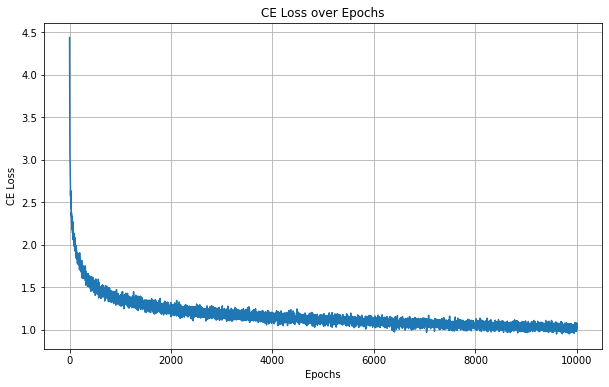

In [23]:
if os.path.exists(loss_path):
    losses = np.load(loss_path)
idx = np.arange(losses.shape[0])
plt.figure(figsize=(10,6))
plt.plot(idx, losses)
plt.title("CE Loss over Epochs")
plt.ylabel("CE Loss")
plt.xlabel("Epochs")
plt.grid()
plt.show()

### Evaluation - Generating New Text Passages

To draw random samples from a categorical distibution, PyTorch provides a class `torch.distributions.categorical.Categorical`.

In [26]:
from torch.distributions.categorical import Categorical 

torch.manual_seed(1)
logits = torch.Tensor([1.0, 1.0, 1.0])
print(f"Probabilities: {nn.functional.softmax(logits, dim=0)}")
m = Categorical(logits=logits)
samples = m.sample((10,))
print(samples.numpy())

Probabilities: tensor([0.3333, 0.3333, 0.3333])
[0 0 0 0 1 0 1 2 1 1]


The logits from above have the same value; therefore, the distribution should be about distributed 1/3 for each class (as the number of samples tend to infinity). If any of the categories from above had a higher value, then the `Categorical` would sample it more often.

In [41]:
def sample(model, starting_str, len_generated_text=500, scale_factor=1.0):
    """
    Perform autoregression and generate a string of length len_generated_text.
    Scale factor is inversely proportional to the entropy of Categorical sampling. 
    """
    encoded_input = torch.Tensor([char2int[ch] for ch in starting_str])
    encoded_input = torch.reshape(encoded_input, (1, -1))
    generated_str = starting_str

    model.cpu()
    with torch.no_grad():
        model.eval()
        hidden, cell = model.init_hidden(1)
        # pass to RNN one integer at a time to update hidden states
        for c in range(len(starting_str) - 1):
            _, hidden, cell = model(encoded_input[:,c].view(1).to(torch.int64), hidden, cell)

        # last character passed to RNN to generate a new character
        last_char = encoded_input[:, -1]
        # perform autoregression (process of consuming generated sequence as input to generate new ones)
        for i in range(len_generated_text):
            logits, hidden, cell = model(last_char.view(1).to(torch.int64), hidden, cell)
            logits = torch.squeeze(logits, 0)
            scaled_logits = logits * scale_factor
            m = Categorical(logits=scaled_logits)
            last_char = m.sample()
            generated_str += str(char_array[last_char])

    return generated_str

In [51]:
# generate some new text
torch.manual_seed(1)
print(sample(model, starting_str="The lonely spirit"))

The lonely spirit just foreseing scenty views, but was made himself distant bluck? It is in the raging trouteers,
with its entirely condecture; but twenty miles from this side in the
fam, the jouthern and obliged to load the slopes of the
coast.

“Whano, Pencroft,” observed Spilett.

“Fiber, or quadrupeds,” answered the engineer, therefore, the advantaging of the shores of the Mercy and Gideon Spilett.

However, the settlers’ candle, motionless, such very easily as if how passed.
Genexating from the convicts, st
